In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## General settings

In [2]:
sns.set_style('whitegrid')
cols_objectives = ['F1', 'F2', 'F3', 'F4', 'F5']
col_target = 'TechniqueAlgorithm'

## Processing the results for all the datasets

In [3]:
def sanitize_dataset(dataset_name):
    # removing all base classifiers
    base_algorithms = ['GradientBoostingClassifier', 'LGBMClassifier', 'LogisticRegression', 'SGDClassifier']

    df = pd.read_csv(f'outputs/df_results{dataset_name}.csv', delimiter='\t', encoding='utf-8', index_col=0).sort_values(by=['Technique', 'Algorithm', 'Classifier'])
    df.loc[df['Technique']=='AIF360', 'Algorithm'] = 'AdversarialDebiasing'
    df.loc[df['Technique']=='Voting', 'Algorithm'] = 'VotingClassifier'
    
    df = df[~df['Classifier'].isin(base_algorithms)].drop('Classifier', axis=1).replace({'F1': 'Top 1 (F1)',
                                                                                         'F2': 'Top 1 (F2)',
                                                                                         'F3': 'Top 1 (F3)',
                                                                                         'F4': 'Top 1 (F4)',
                                                                                         'F5': 'Top 1 (F5)',
                                                                                         'ProposalBest': 'Proposal',
                                                                                         'ProposalWeighted': 'Proposal'})
    df['TechniqueAlgorithm'] = df['Technique'] + ', ' + df['Algorithm']
    
    # melting the dataset
    #df_results_melt = df[~df['Technique'].isin(['Original', 'Voting'])][cols_objectives + [col_target]].melt(id_vars=col_target)
    df_results_melt = df[~df['Technique'].isin(['Original'])][cols_objectives + [col_target]].melt(id_vars=col_target)
    df_results_melt = df_results_melt.rename(columns={'TechniqueAlgorithm': 'Technique'})
    df_results_melt.to_csv(f'outputs/df_results{dataset_name}_melt.csv', sep='\t', encoding='utf-8', index=False)
    
    return df, df_results_melt

def get_plots(df_results_melt, is_box=True):
    x = 'Technique'
    y = 'value'

    order = ['Proposal, Top 100 (Balanced)',
             'Proposal, Top 1 (F1)',
             'Proposal, Top 1 (F2)',
             'Proposal, Top 1 (F3)',
             'Proposal, Top 1 (F4)',
             'Proposal, Top 1 (F5)',
             'Proposal, Top 1 (Balanced)',
             'AIF360, AdversarialDebiasing',
             'Fairlearn, equalized_odds',
             'Fairlearn, false_positive_rate_parity',
             'Fairlearn, true_positive_rate_parity',
             'scikit-lego, DemographicParityClassifier',
             'scikit-lego, EqualOpportunityClassifier',
             'Voting, VotingClassifier']

    for i in range(len(cols_objectives)):
        col = cols_objectives[i]
        data = df_results_melt[df_results_melt['variable']==col].copy()
        data['index'] = data['Technique']
        data = data.set_index('index').loc[data.index.intersection(order)]

        plt.figure(figsize=(10, 5))
        if is_box:
            box_plot = sns.boxplot(data=data, orient='h', y=x, x=y)
            medians = data.groupby([x])[y].median().loc[data.index.intersection(order)]
            offset_x = (data[y].max() - data[y].min()) * 0.05 # offset from median for display
            for tick in box_plot.get_yticks():
                box_plot.text(medians[tick] - offset_x, tick, '{:.5f}'.format(medians[tick]),
                              horizontalalignment='center', verticalalignment='center',
                              size='small', weight='semibold')
        else:
            box_plot = sns.violinplot(data=data, orient='h', y=x, x=y)
            
        box_plot.set_xlabel(f'F{i+1}')

        plt.show()

def get_dataframe_with_statistics(df):
    df_filtered = df[cols_objectives + [col_target]]
    df_mean = df_filtered.groupby(col_target, as_index=False).mean()
    df_std = df_filtered.groupby(col_target, as_index=False).std(ddof=0)

    for col in cols_objectives:
        df_mean = df_mean.rename(columns={col: f'{col}_mean'})
        df_std = df_std.rename(columns={col: f'{col}_std'})

    df_result = pd.concat([df_mean, df_std.drop(col_target, axis=1)], axis=1)
    for col in cols_objectives:
        df_result[col] = df_result[f'{col}_mean'].map('{:.5f}'.format)
        df_result[col] += ' ± ' + df_result[f'{col}_std'].map('{:.5f}'.format)

    df_result = df_result[[col_target] + cols_objectives]
    display('Dataset with means and standard deviation:')
    display(df_result)
    
    df_filtered = df[~df['Technique'].isin(['Original', 'Voting'])][cols_objectives + [col_target]]
    display('Dataset with medians:')
    df_median = df_filtered.groupby(col_target, as_index=False).median()
    display(df_median)
    
    df_result.to_csv(f'outputs/df_{dataset}_means_std.csv', sep='\t', encoding='utf-8', index=False)
    df_median.to_csv(f'outputs/df_{dataset}_medians.csv', sep='\t', encoding='utf-8', index=False)

## Reading the results

In [4]:
df = pd.read_csv(f'outputs/df_resultsgerman.csv', delimiter='\t', encoding='utf-8', index_col=0)#[['Technique', 'Algorithm', 'Classifier']]#.drop_duplicates()

df.loc[df['Technique']=='AIF360', 'Algorithm'] = 'AdversarialDebiasing'
df.loc[df['Technique']=='Voting', 'Algorithm'] = 'VotingClassifier'

base_algorithms = ['GradientBoostingClassifier', 'LGBMClassifier', 'LogisticRegression', 'SGDClassifier']
df[~df['Classifier'].isin(base_algorithms)][['Technique', 'Algorithm', 'Classifier']].drop_duplicates()

,Technique,Algorithm,Classifier
0,Voting,VotingClassifier,VotingClassifier
1,Fairlearn,false_positive_rate_parity,VotingClassifier
2,Fairlearn,true_positive_rate_parity,VotingClassifier
3,Fairlearn,equalized_odds,VotingClassifier
4,scikit-lego,DemographicParityClassifier,OneVsRestClassifier
5,scikit-lego,EqualOpportunityClassifier,OneVsRestClassifier
6,Proposal,nsga2,FairVotingClassifier
7,ProposalWeighted,F1_nsga2,FairVotingClassifier
8,ProposalWeighted,F2_nsga2,FairVotingClassifier
9,ProposalWeighted,F3_nsga2,FairVotingClassifier


### Plotting

'Processing the dataset german:'

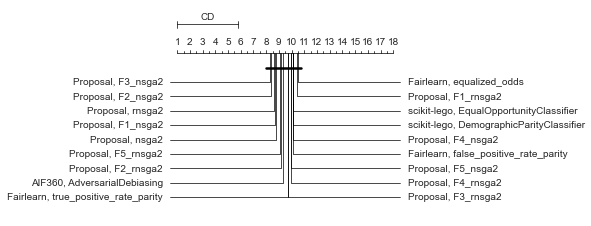

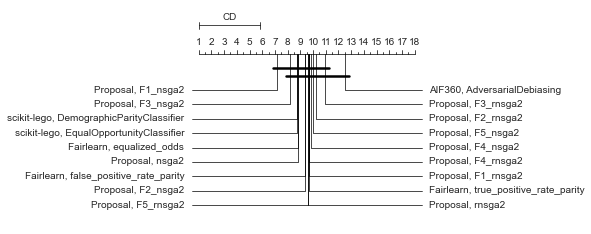

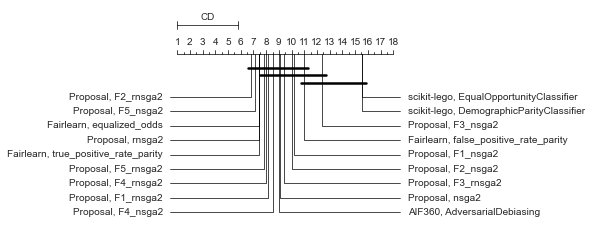

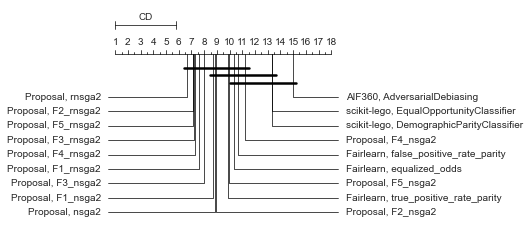

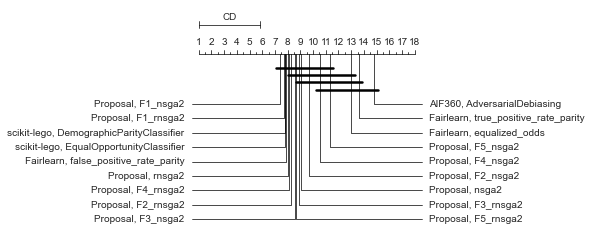

'Processing the dataset adult:'

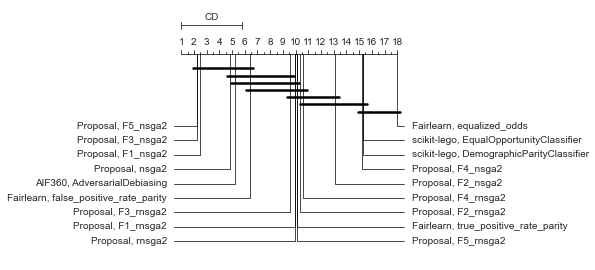

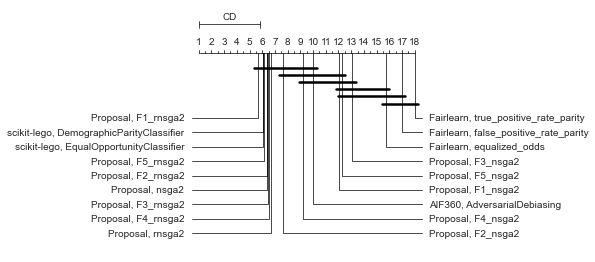

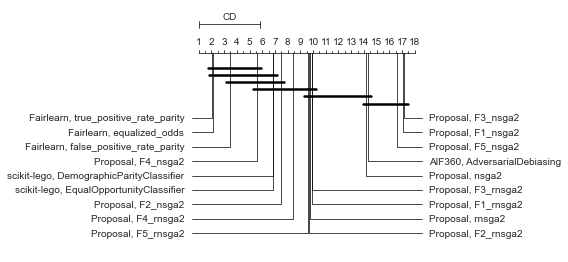

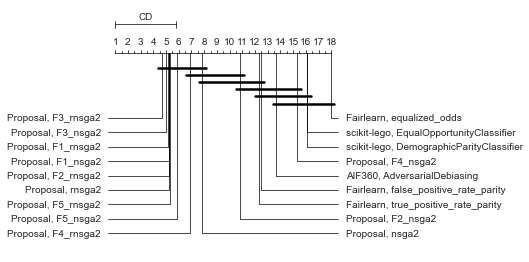

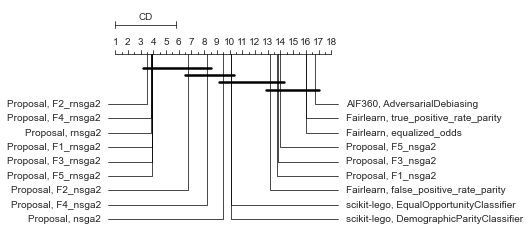

'Processing the dataset compas:'

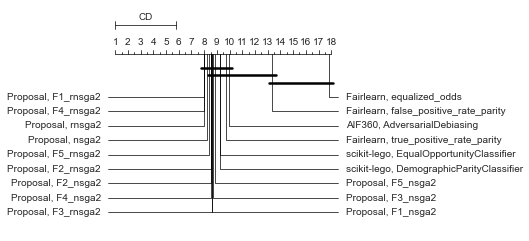

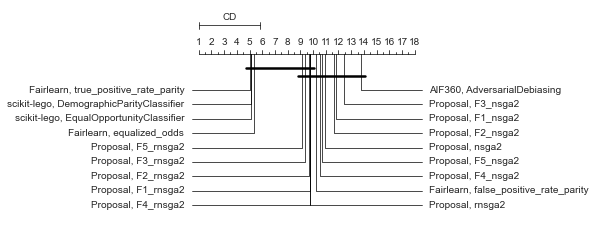

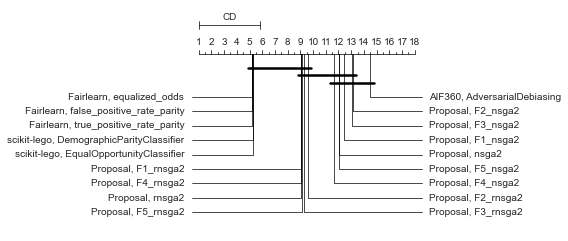

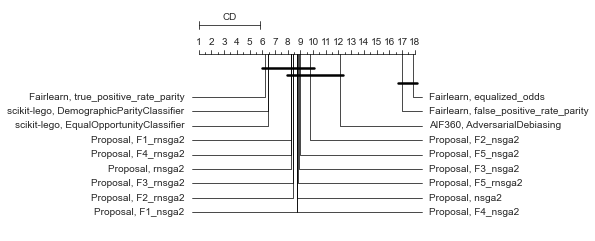

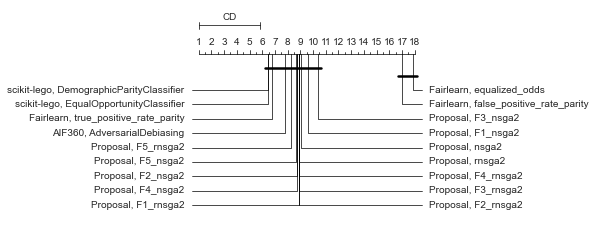

In [5]:
import Orange
import matplotlib.pyplot as plt

objectives = {'F1': True, 'F2': True, 'F3': False, 'F4': False, 'F5': False}
for dataset in ['german', 'adult', 'compas']:
    display(f'Processing the dataset {dataset}:')
    df, df_results_melt = sanitize_dataset(dataset)

    for objective in objectives.keys():
        df_filtered = df[~df['Algorithm'].isin(['Top 100 (Balanced)', 'Top 1 (F1)', 'VotingClassifier',
                                                'Top 1 (F2)', 'Top 1 (F3)', 'Top 1 (F4)', 'Top 1 (F5)'])]
        df_cd_results = pd.pivot_table(df_filtered, index='Seed', values=objective,
                                       columns=['TechniqueAlgorithm']).rank(ascending=objectives[objective], axis=1).mean()

        cd = Orange.evaluation.compute_CD(df_cd_results.values.tolist(), 30) #tested on 30 datasets
        Orange.evaluation.graph_ranks(df_cd_results.values.tolist(), df_cd_results.index.tolist(), cd=cd, width=6, textspace=1.5)
        plt.show()